# Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import warnings
from statsmodels.tsa.arima_model import ARIMA
import timeit
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from fbprophet import Prophet

# Dataprep

In [2]:
# read time series
ts = pd.read_csv('./data/dataframe_yearly.csv', index_col=0, usecols=[0,2])

# print out first values
ts.head()

,ice_extent
Year,
1979,12.349634
1980,12.349545
1981,12.147230
1982,12.467336
1983,12.353095


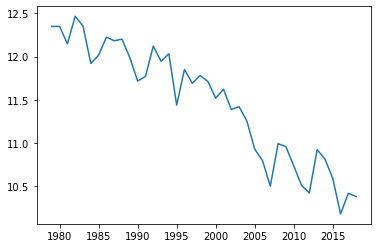

In [3]:
# plot time series
plt.plot(ts)

## Differentiatie

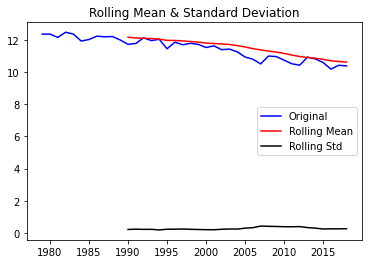

In [4]:
# define method to visualise the stationarity of a time series
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
# check stationarity of time serie
test_stationarity(ts)

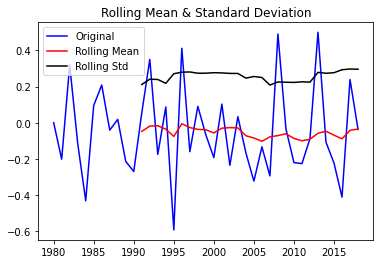

In [5]:
# take the random walk difference of the time serie
ts_diff = ts - ts.shift(1)
ts_diff = ts_diff.dropna()

# display stationarity of the newly differenced time serie
test_stationarity(ts_diff)

## Cross validation setup

In [6]:
# initialize TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits = 8)

# loop trough all split time series that have a trainingsset with more than 20 values
for train_index, test_index in tscv.split(ts_diff):
    if train_index.size > 20:

        # initialize cross validation train and test sets
        cv_train, cv_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]
        
         # visiualize cross_validation structure for reference
        print("TRAIN:", train_index.size)
        print("TEST:", test_index.size)
        print()

TRAIN: 23
TEST: 4

TRAIN: 27
TEST: 4

TRAIN: 31
TEST: 4

TRAIN: 35
TEST: 4



## General methods

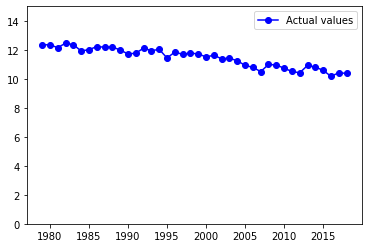

In [7]:
# plot
plt.plot(ts, marker='o', color='blue',label='Actual values')
plt.ylim([0,15])
plt.legend()

plt.show()

In [8]:
# define functions used troughout the notebook

# define function for plotting last prediction and the actual data
def full_graph(predicted_diff, title):
    
    # format predictions by adding NaN values in front
    predictionsArray = np.asarray(revert_diff(predicted_diff, ts))
    zerosArray = np.zeros(ts.values.size-len(predictionsArray.flatten()))
    cleanPrediction = pd.Series(np.concatenate((zerosArray,predictionsArray))).replace(0,np.NaN)
    cleanPrediction.index = ts.index.values
    
    # plot
    plt.title(title)
    plt.plot(ts, marker='o', color='blue',label='Actual values')
    plt.plot(cleanPrediction, marker='o', color='red',label='Last 4 year prediction')
    plt.ylim([0,15])
    plt.legend()

    plt.show()

# define function for reverting a differenced dataset
def revert_diff(predicted_diff, og_data):
    
    # retrieve last value
    last_value = og_data.iloc[-predicted_diff.size-1][0]
    
    # initialize reverted array
    predicted_actual = np.array([])
    
    # add each value in the differenced array with the last actual value
    for value_diff in predicted_diff:
        actual_value = last_value + value_diff
        predicted_actual = np.append(predicted_actual, actual_value)
        last_value = actual_value
        
    return predicted_actual

# ARIMA

In [9]:
%%time
# ARIMA
from statsmodels.tsa.arima_model import ARIMA
import itertools
import warnings
import sys
from sklearn.metrics import mean_absolute_error



# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 5)
d = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# initialize variables
best_pdq = pdq
best_mean_mae = np.inf

# specify to ignore warning messages to reduce visual clutter
warnings.filterwarnings("ignore") 

# loop trough all possible parameter combinations of pdq
for param in pdq:
    print(param)
    
    # some parametercombinations might lead to crash, so catch exceptions and continue
    try:  
        
        # initialize the array which will contain the mean average errors
        maes = []
        
        # loop trough all split time series that have a trainingsset with more than 20 values
        for train_index, test_index in tscv.split(ts_diff):
            if train_index.size > 20:
                
                # initialize cross validation train and test sets
                cv_train, cv_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

                # build model
                model = ARIMA(cv_train, order=(param))
                
                # fit model
                model_fit = model.fit()

                # make predictions
                predictions =  model_fit.predict(start=len(cv_train), end=len(cv_train)+cv_test.size-1, dynamic=False)
                
                # renaming for clarity
                prediction_values = predictions.values
                true_values = cv_test.values
                
                # error calculation this part of the cross validation
                maes.append(mean_absolute_error(true_values, prediction_values))

        
        # error calculation for this parameter combination
        mean_mae = np.mean(maes)
        print('MAE: ' + str(mean_mae))    

        # store parameters resulting in the lowest mean MAE
        if mean_mae < best_mean_mae:
            best_mean_mae = mean_mae
            best_maes = maes
            best_pdq = param
            best_predictions = prediction_values
            
    except Exception as e:
        print(e)
        continue

# logging
print()
print('Best MAE = ' + str(best_mean_mae))
print(best_pdq)

# best range(0,10): 

(0, 0, 0)
MAE: 0.20032300657400814
(0, 0, 1)
MAE: 0.2074012843296259
(0, 0, 2)
MAE: 0.20990433179675155
(0, 0, 3)
Input contains NaN, infinity or a value too large for dtype('float64').
(0, 0, 4)
MAE: 0.19801688093363323
(0, 1, 0)
MAE: 0.21780511121268165
(0, 1, 1)
MAE: 0.24127702699986248
(0, 1, 2)
MAE: 0.2649755855739036
(0, 1, 3)
MAE: 0.2924535938219568
(0, 1, 4)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 2, 0)
MAE: 0.22078066197814958
(0, 2, 1)
MAE: 0.27335795820582254
(0, 2, 2)
MAE: 0.28137922538117066
(0, 2, 3)
MAE: 0.3659161989156701
(0, 2, 4)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(1, 0, 0)
MAE: 0.19961999072484204
(1, 0, 1)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model ord

In [10]:
# # result
# best_pdq = (3, 0, 0)

----
IIII
Mean MAE: 0.171 x 1 000 000 km²
MAE of last prediction: 0.103 x 1 000 000 km²
Execution time: 0.360 seconds


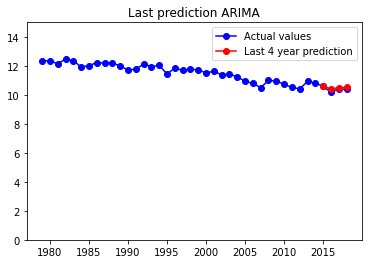

Mean average errors
[0.12511530847905092, 0.2752061283732373, 0.18026943891615582, 0.1025190381166726]


In [11]:
start_time = timeit.default_timer()

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

print("----")

# initialize the array which will contain the mean average errors
maes = []

# loop trough all split time series that have a trainingsset with more than 20 values
for train_index, test_index in tscv.split(ts_diff):
    if train_index.size > 20:

        # initialize cross validation train and test sets
        cv_train, cv_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

        # build model
        arima = ARIMA(cv_train, best_pdq).fit(start_ar_lags=1,disp=False)

        # make predictions
        predictions = arima.forecast(steps=4)
        prediction_values = predictions[0]
        true_values = cv_test.values

        # error calc
        maes.append(mean_absolute_error(true_values, prediction_values))

        # last actual prediction 
        last_prediction_ARIMA = prediction_values

        print("I",end="")

# store results to variables
time_ARIMA = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_ARIMA = mae_mean
last_MAE_ARIMA = maes[-1]

# logging
print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_ARIMA)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_ARIMA)
print('Execution time: %.3f seconds' % time_ARIMA)
full_graph(last_prediction_ARIMA, 'Last prediction ARIMA')
print('Mean average errors')
print(maes)

# LSTM

https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

## Functions 

In [12]:
from keras.layers import Dropout
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
def build_model(raw_seq, n_steps_in, n_steps_out, n_features, n_neurons, dropout, batch_s):
    
    # split into samples
    X, y = split_sequence(raw_seq.values.flatten(), n_steps_in, n_steps_out)
    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # define model
    model = Sequential()
    model.add(LSTM(n_neurons, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mae')
    
    # fit model
    model.fit(X, y, batch_size=batch_s, epochs=100, verbose=0)
    
    return model


def predict(x_input, model, n_features):
    n_features = 1
    
    # reshape data
    x_input = x_input.reshape((1, n_steps_in, n_features))
    
    # predict
    yhat = model.predict(x_input, verbose=0)
    
    return yhat

## Determine hyperparameters 

----
IIII
1
0
1
0.19881913837765874

----
IIII
1
0
8
0.19469613674840258

----
IIII
1
0.5
1
0.1968436788553646

----
IIII
1
0.5
8
0.1973167053989071

----
IIII
1
0.99
1
0.19719196002867903

----
IIII
1
0.99
8
0.1973053809125196

----
IIII
10
0
1
0.19957536370241793

----
IIII
10
0
8
0.20061682897153932

----
IIII
10
0.5
1
0.20136646437873795

----
IIII
10
0.5
8
0.2011056887568194

----
IIII
10
0.99
1
0.2010137977187867

----
IIII
10
0.99
8
0.2008659693430802

----
IIII
20
0
1
0.20385907562319444

----
IIII
20
0
8
0.20395767415025975

----
IIII
20
0.5
1
0.2038327608724476

----
IIII
20
0.5
8
0.2037144183536465

----
IIII
20
0.99
1
0.20341714329561042

----
IIII
20
0.99
8
0.2031811745722973

Best:
N neurons
1
Dropout rate
0
Batch size
8
MAE
0.19469613674840258
Wall time: 3min 10s


<BarContainer object of 18 artists>

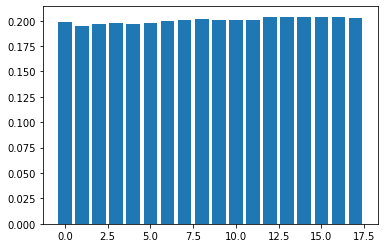

In [24]:
%%time

# Disabled tf warning because of visual clutter
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# constant variables
n_steps_in = 4
n_steps_out = 4
n_features  = 1
maes = []
global_maes = []

# optimizable variables
n_neurons_array = [1,10,20]
dropout_array = [0,0.5,0.99]
batch_size_array = [1,8]


# initialize values
best_MAE = 100
best_n_neurons = 0
best_activation = 'none'
best_dropout = 0
best_batch_size = 0

# loop over all possible parameter combinations
for n_neurons in n_neurons_array:
    for dropout in dropout_array:
        for batch_size in batch_size_array:

            print("----")
            
            # loop trough all split time series that have a trainingsset with more than 20 values
            for train_index, test_index in tscv.split(ts_diff): 
                if train_index.size > 20:  
                    
                    # initialize cross validation train and test sets
                    y_train, y_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

                    # build model
                    lstm_model = build_model(y_train, n_steps_in, n_steps_out, n_features, n_neurons, dropout, batch_size)

                    # make predictions
                    x_input = array(y_test)
                    y_predicted = predict(x_input, lstm_model, n_features).flatten()
                    y_actual = y_test.values

                    # error calculation this part of the cross validation
                    maes.append(mean_absolute_error(y_actual, y_predicted))

                    print("I",end="")

                    # last actual prediction 
                    last_prediction_LSTM = y_predicted

            # error calculation for this parameter combination
            MAE_LSTM = np.mean(maes)
            last_MAE_LSTM = maes[-1]
            global_maes.append(MAE_LSTM)

            # store parameters resulting in the lowest mean MAE
            if best_MAE > MAE_LSTM:
                best_n_neurons = n_neurons
                best_dropout = dropout
                best_batch_size = batch_size
                best_MAE = MAE_LSTM
                
            # log values for parameter combination
            print()
            print(n_neurons)
            print(dropout)
            print(batch_size)
            print(MAE_LSTM)
            print()    

# log parameter combination with best result
print('Best:')
print('N neurons')
print(best_n_neurons)
print('Dropout rate')
print(best_dropout)
print('Batch size')
print(best_batch_size)
print('MAE')
print(best_MAE)
plt.bar(range(0,len(global_maes)), global_maes)

In [25]:
# Run #1 Best:
# 1
# 0
# 1
# 0.1919512481592649
# Wall time: 8min 36s

# Run #2 Best:
# 1
# 0.5
# 1
# 0.19969739902546374
# Wall time: 7min 16s

# Run #3 Best:
# 5
# 0.99
# 8
# 0.20111841616444215
# Wall time: 6min 47s

In [26]:
best_n_neurons = 1
best_dropout = 0
best_batch_s = 8

## Final result LSTM

----
IIII
Mean MAE: 0.200 x 1 000 000 km²
MAE of last prediction: 0.215 x 1 000 000 km²
Execution time: 5.480 seconds


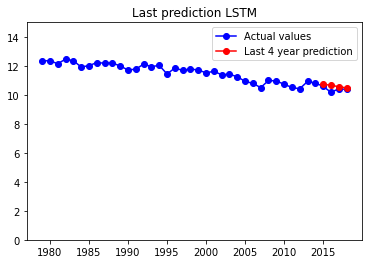

Mean average errors
[0.1527431455020163, 0.23552654839108333, 0.19871178303483195, 0.21470190819788382]
Wall time: 5.6 s


In [27]:
%%time

start_time = timeit.default_timer()

# Disabled tf warning because of visual clutter
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# constant variables
n_steps_in = 4
n_steps_out = 4
n_features  = 1
maes = []


# optimizable variables
n_neurons = best_n_neurons
dropout = best_dropout
batch_s = best_batch_s

print("----")

# loop trough all split time series that have a trainingsset with more than 20 values
for train_index, test_index in tscv.split(ts_diff):
    if train_index.size > 20:  
        # initialize cross validation train and test sets
        y_train, y_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

        # build model
        lstm_model = build_model(y_train, n_steps_in, n_steps_out, n_features, n_neurons, dropout, batch_s)

        # make predictions
        x_input = array(y_test)
        y_predicted = predict(x_input, lstm_model, n_features).flatten()
        y_actual = y_test.values

        # error calc
        maes.append(mean_absolute_error(y_actual, y_predicted))

        print("I",end="")

# last actual prediction 
last_prediction_LSTM = y_predicted
 
# store variables
time_LSTM = timeit.default_timer() - start_time
MAE_LSTM = np.mean(maes)
last_MAE_LSTM = maes[-1]

# visualisation
print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_LSTM)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_LSTM)
print('Execution time: %.3f seconds' % time_LSTM)
full_graph(last_prediction_LSTM, 'Last prediction LSTM')
print('Mean average errors')
print(maes)

### Prophet

In [28]:
# formatting dataframe
ts_formated_prophet = ts_diff.reset_index().rename(columns = {'Year' : 'ds', 'ice_extent' : 'y'})
ts_formated_prophet['ds'] = pd.DataFrame(pd.to_datetime(ts_formated_prophet['ds'].astype(str), format='%Y'))

In [38]:
# Python
import itertools
import numpy as np
import pandas as pd

# define dataframe
df = ts_formated_prophet

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1, 2, 5, 10, 15, 20, 25],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# initialize variables
maes = []  
global_maes = []
best_MAE_prophet = np.inf

# Use cross validation to evaluate all parameters
for params in all_params:

    # loop trough all split time series that have a trainingsset with more than 20 values
    for train_index, test_index in tscv.split(ts_formated_prophet):    
        if train_index.size > 20:  
            
            # initialize cross validation train and test sets
            train  = ts_formated_prophet.iloc[train_index]
            y_test = ts_formated_prophet.iloc[test_index][['y']].values.flatten()
            X_test = ts_formated_prophet.iloc[test_index][['ds']]

            # Fit model with given params
            model = Prophet(**params, weekly_seasonality=False, daily_seasonality=False)
            model = model.fit(train)
            
            # make predictions
            forecast = model.predict(X_test)
            y_pred = forecast['yhat'].values
            
            # last actual prediction 
            last_prediction_prophet = y_pred
            
            # error calculation this part of the cross validation
            maes.append(mean_absolute_error(y_test, y_pred))
            
    # error calculation for this parameter combination
    MAE_prophet = np.mean(maes)
    last_MAE_prophet = maes[-1]
    global_maes.append(MAE_prophet)
    
    # logging
    print('changepoint_prior_scale: ' + str(params['changepoint_prior_scale']))
    
    # store parameters resulting in the lowest mean MAE
    if best_MAE_prophet > MAE_prophet:
        best_params = params
        best_MAE_prophet = MAE_prophet

# log optimal result          
print('changepoint_prior_scale: ' + str(best_params['changepoint_prior_scale']))
print(best_MAE_prophet)
            

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


changepoint_prior_scale: 0.001


INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


changepoint_prior_scale: 0.01


INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


changepoint_prior_scale: 0.1


INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


changepoint_prior_scale: 1


INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


changepoint_prior_scale: 2


INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


changepoint_prior_scale: 5


INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


changepoint_prior_scale: 10


INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


changepoint_prior_scale: 15


INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


changepoint_prior_scale: 20


INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


changepoint_prior_scale: 25
changepoint_prior_scale: 2
0.2109848853288287


In [39]:
# best_params = {'changepoint_prior_scale': 2}

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Mean MAE: 0.209 x 1 000 000 km²
MAE of last prediction: 0.245 x 1 000 000 km²
Execution time: 8.557 seconds


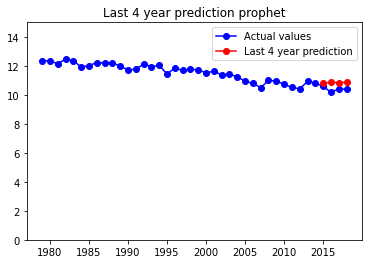

Mean average errors
[0.126584592587182, 0.2432586886102241, 0.22013313821990807, 0.24456896573145737]
Wall time: 8.69 s


In [40]:
%%time

# Disabled tf warning because of clutter
warnings.filterwarnings("ignore") # specify to ignore warning messages

start_time = timeit.default_timer()

# initialize variables
maes = []

for train_index, test_index in tscv.split(ts_formated_prophet):
    if train_index.size > 20:  
        
        # initialize cross validation train and test sets
        train  = ts_formated_prophet.iloc[train_index]
        y_test = ts_formated_prophet.iloc[test_index][['y']].values.flatten()
        X_test = ts_formated_prophet.iloc[test_index][['ds']]

        # build model
        model = Prophet(**best_params, weekly_seasonality=False, daily_seasonality=False)
        model.fit(train)

        # make predictions
        forecast = model.predict(X_test)
        y_pred = forecast['yhat'].values

        # error calc
        maes.append(mean_absolute_error(y_test, y_pred))

        # last actual prediction 
        last_prediction_prophet = y_pred


# store results
time_Prophet = timeit.default_timer() - start_time
MAE_Prophet = np.mean(maes)
last_MAE_Prophet = maes[-1]

# visualize results
print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_Prophet)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_Prophet)
print('Execution time: %.3f seconds' % time_Prophet)
full_graph(last_prediction_prophet, "Last 4 year prediction prophet")
print('Mean average errors')
print(maes)

# Evaluation

In [33]:
# formatting
results = [[MAE_ARIMA,time_ARIMA,last_MAE_ARIMA],[MAE_LSTM,time_LSTM,last_MAE_LSTM],[MAE_Prophet,time_Prophet,last_MAE_Prophet]]

# display results
pd.DataFrame(results, columns=['Mean MAE (x 1 000 000 km\u00b2)','Execution time (s)','Last MAE (x 1 000 000 km\u00b2)'],index=['ARIMA','LSTM','Prophet']).round(decimals=3)


,Mean MAE (x 1 000 000 km²),Execution time (s),Last MAE (x 1 000 000 km²)
ARIMA,0.171,0.360,0.103
LSTM,0.200,5.480,0.215
Prophet,0.252,8.891,0.308


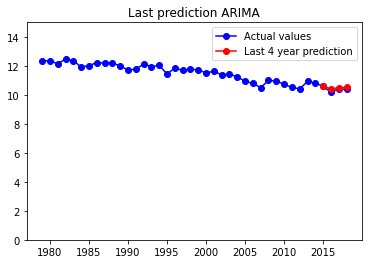

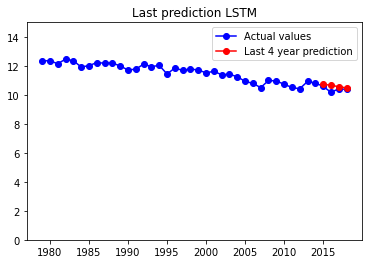

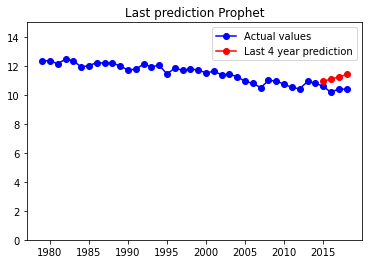

In [34]:
# visualize results of last prediction
full_graph(last_prediction_ARIMA, "Last prediction ARIMA")
full_graph(last_prediction_LSTM, "Last prediction LSTM")
full_graph(last_prediction_prophet, "Last prediction Prophet")